seperate VMD transformation:
applied it to the training and testing seperately.

The reason that I consider this script have no data leakage issue:

* didn't shuffle time series
* didn't peek into test data to tune parameters
* apply VMD only on past data(training); used as input feature

Past WVHT from NDBC -> VMD -> Input to LSTM -> Predict future WVHT

In [1]:
!pip install vmdpy

In [ ]:
from vmdpy import VMD
import math
import pandas as pd
import numpy as np
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from vmdpy import VMD
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Flatten
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [37]:
# Load Data
df = pd.read_csv("final_ndbc_data.csv")
print(f"Dataset shape: {df.shape}")

Loading data...
Dataset shape: (17544, 6)


In [38]:
# Check for NaN values in the raw data
print("NaN values in raw data:", df.isna().sum())

NaN values in raw data: timestamp    0
WVHT         0
DPD          0
APD          0
MWD          0
WTMP         0
dtype: int64


In [39]:
# Split data into train and test sets FIRST to prevent data leakage
split = int(0.8 * len(df))
train_df = df[:split].copy()
test_df = df[split:].copy()

print(f"Training set size: {train_df.shape[0]}")
print(f"Test set size: {test_df.shape[0]}")

# Fill any NaN values in the raw data    (This is just check if there are missing value)
for col in df.columns:
    if df[col].isna().any():
        # Fill with median to be robust to outliers
        median_val = train_df[col].median()
        train_df[col].fillna(median_val, inplace=True)
        test_df[col].fillna(median_val, inplace=True)
        print(f"Filled NaN values in {col} with median: {median_val}")

Training set size: 14035
Test set size: 3509


In [40]:
# STEP 3: Apply VMD separately to training and test sets
# VMD Parameters
# I do not know why these parameters are set like this, but based on the github
# code that I found and Claude, this seems to be right

alpha = 2000
tau = 0.
K = 5
DC = 0
init = 1
tol = 1e-7

# Process training data
print("Applying VMD to training data...")
train_wvht = train_df['WVHT'].values
try:
    u_train, _, _ = VMD(train_wvht, alpha, tau, K, DC, init, tol)
    if np.isnan(u_train).any():
        print("Warning: VMD produced NaNs in training data. Adjusting parameters...")
        alpha = 1000  # Try a more conservative alpha
        u_train, _, _ = VMD(train_wvht, alpha, tau, K, DC, init, tol)
except Exception as e:
    print(f"VMD error on training data: {e}")
    # Fallback to simpler decomposition
    u_train = np.zeros((K, len(train_wvht)))
    for i in range(K):
        u_train[i] = train_wvht / K  # Simple equal division as fallback

train_vmd_df = pd.DataFrame(u_train.T, columns=[f'VMD_{i+1}' for i in range(K)])
print("VMD on training data complete")

# Process test data separately
print("Applying VMD to test data...")
test_wvht = test_df['WVHT'].values
try:
    u_test, _, _ = VMD(test_wvht, alpha, tau, K, DC, init, tol)  # Use same alpha as training
    if np.isnan(u_test).any():
        print("Warning: VMD produced NaNs in test data. Using backup approach...")
        # Try with different parameters
        u_test, _, _ = VMD(test_wvht, 500, tau, K, DC, init, 1e-5)
except Exception as e:
    print(f"VMD error on test data: {e}")
    # Fallback to simpler decomposition
    u_test = np.zeros((K, len(test_wvht)))
    for i in range(K):
        u_test[i] = test_wvht / K  # Simple equal division as fallback

test_vmd_df = pd.DataFrame(u_test.T, columns=[f'VMD_{i+1}' for i in range(K)])
print("VMD on test data complete")

# Check for NaN values in VMD output
print("NaN in train_vmd_df:", train_vmd_df.isna().sum().sum())
print("NaN in test_vmd_df:", test_vmd_df.isna().sum().sum())

# Handle any remaining NaNs in the VMD components
for col in train_vmd_df.columns:
    if train_vmd_df[col].isna().any():
        print(f"Filling NaNs in {col} for training data")
        train_vmd_df[col].fillna(0, inplace=True)

for col in test_vmd_df.columns:
    if test_vmd_df[col].isna().any():
        print(f"Filling NaNs in {col} for test data")
        test_vmd_df[col].fillna(0, inplace=True)

Applying VMD to training data...
VMD on training data complete
Applying VMD to test data...
VMD on test data complete
NaN in train_vmd_df: 0
NaN in test_vmd_df: 0


In [41]:
# Combine VMD features with other ocean features
# For training data
train_features = pd.concat([
    train_vmd_df.reset_index(drop=True),
    train_df[['DPD', 'APD', 'MWD', 'WTMP']].reset_index(drop=True)
], axis=1)
train_target = train_df['WVHT'].values

# For test data
test_features = pd.concat([
    test_vmd_df.reset_index(drop=True),
    test_df[['DPD', 'APD', 'MWD', 'WTMP']].reset_index(drop=True)
], axis=1)
test_target = test_df['WVHT'].values

# Final NaN check before scaling
print("NaN in train_features:", train_features.isna().sum().sum())
print("NaN in test_features:", test_features.isna().sum().sum())

# Fill any remaining NaNs
if train_features.isna().sum().sum() > 0:
    train_features.fillna(0, inplace=True)
if test_features.isna().sum().sum() > 0:
    test_features.fillna(0, inplace=True)

NaN in train_features: 5
NaN in test_features: 5


In [42]:
# Scale inputs using only training data
print("Scaling data...")
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(train_features)
X_test_scaled = scaler.transform(test_features)  # using scaler fitted only on training data

# Verify no NaNs after scaling
print("NaN in X_train_scaled:", np.isnan(X_train_scaled).sum())
print("NaN in X_test_scaled:", np.isnan(X_test_scaled).sum())

# If there are any NaNs after scaling, replace them
if np.isnan(X_train_scaled).any():
    print("Replacing NaNs in training data after scaling")
    X_train_scaled = np.nan_to_num(X_train_scaled)

if np.isnan(X_test_scaled).any():
    print("Replacing NaNs in test data after scaling")
    X_test_scaled = np.nan_to_num(X_test_scaled)

Scaling data...
NaN in X_train_scaled: 0
NaN in X_test_scaled: 0


In [43]:
# Create sequences for LSTM
print("Creating sequences...")
def create_sequences(X, y, n_past):
    X_seq, y_seq = [], []
    for i in range(n_past, len(X)):
        X_seq.append(X[i - n_past:i])
        y_seq.append(y[i])
    return np.array(X_seq), np.array(y_seq)

n_past = 60  # sequence length
# Ensure sequence length isn't too long for the data
if n_past > len(X_test_scaled) // 2:
    n_past = max(10, len(X_test_scaled) // 3)
    print(f"Adjusted sequence length to {n_past} based on data size")

# Create sequences separately for train and test
X_train, y_train = create_sequences(X_train_scaled, train_target, n_past)
X_test, y_test = create_sequences(X_test_scaled, test_target, n_past)

print(f"Training sequences shape: {X_train.shape}")
print(f"Test sequences shape: {X_test.shape}")

# Final check for NaNs in sequences
print("NaN in X_train sequences:", np.isnan(X_train).sum())
print("NaN in X_test sequences:", np.isnan(X_test).sum())

Creating sequences...
Training sequences shape: (13975, 60, 9)
Test sequences shape: (3449, 60, 9)
NaN in X_train sequences: 0
NaN in X_test sequences: 0


In [44]:
# Define LSTM Model
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=X_train.shape[1:]),
    LSTM(64, return_sequences=True),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

# Use a more conservative learning rate and add gradient clipping to prevent NaN during training
optimizer = Adam(learning_rate=0.001, clipnorm=1.0)
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

Building model...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [45]:
# Train Model
print("Training model...")
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=30,
    batch_size=32,
    verbose=1
)


Training model...
Epoch 1/30
437/437 ━━━━━━━━━━━━━━━━━━━━ 63s 131ms/step - loss: 0.1580 - mae: 0.2653 - val_loss: 0.0350 - val_mae: 0.1407
Epoch 2/30
437/437 ━━━━━━━━━━━━━━━━━━━━ 62s 142ms/step - loss: 0.0296 - mae: 0.1265 - val_loss: 0.0351 - val_mae: 0.1353
Epoch 3/30
437/437 ━━━━━━━━━━━━━━━━━━━━ 77s 130ms/step - loss: 0.0247 - mae: 0.1162 - val_loss: 0.0225 - val_mae: 0.1060
Epoch 4/30
437/437 ━━━━━━━━━━━━━━━━━━━━ 60s 136ms/step - loss: 0.0232 - mae: 0.1108 - val_loss: 0.0276 - val_mae: 0.1203
Epoch 5/30
437/437 ━━━━━━━━━━━━━━━━━━━━ 79s 130ms/step - loss: 0.0207 - mae: 0.1044 - val_loss: 0.0305 - val_mae: 0.1266
Epoch 6/30
437/437 ━━━━━━━━━━━━━━━━━━━━ 82s 130ms/step - loss: 0.0192 - mae: 0.0986 - val_loss: 0.0215 - val_mae: 0.1082
Epoch 7/30
437/437 ━━━━━━━━━━━━━━━━━━━━ 81s 127ms/step - loss: 0.0195 - mae: 0.0996 - val_loss: 0.0231 - val_mae: 0.1040
Epoch 8/30
437/437 ━━━━━━━━━━━━━━━━━━━━ 88s 142ms/step - loss: 0.0174 - mae: 0.0930 - val_loss: 0.0205 - val_mae: 0.1020
Epoch 9/30
437

In [48]:
# Predict and Evaluate
print("Evaluating model...")
pred = model.predict(X_test).flatten()

# Calculate metrics
rmse = math.sqrt(mean_squared_error(y_test, pred))
mae = mean_absolute_error(y_test, pred)
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE: {mae:.4f}")

Evaluating model...
108/108 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step
Test RMSE: 0.1176
Test MAE: 0.0794


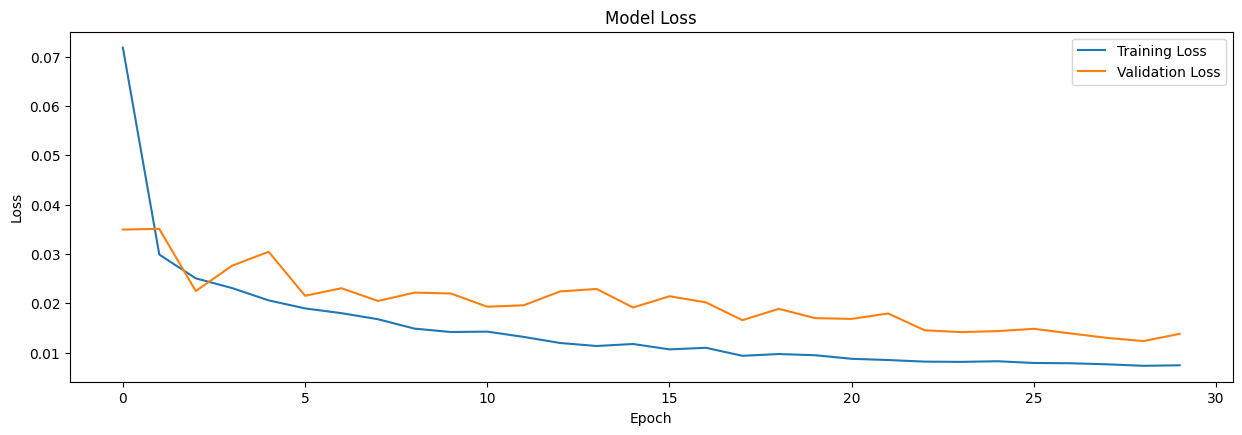

In [49]:
# Plot results
plt.figure(figsize=(15, 10))

# Plot training & validation loss
plt.subplot(2, 1, 1)
plt.plot(history.history['loss'], label='Training Loss')
if 'val_loss' in history.history and not np.isnan(history.history['val_loss']).all():
    plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

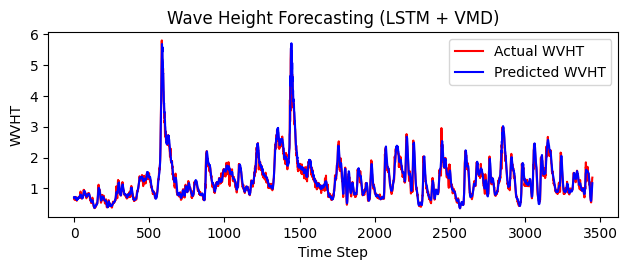

In [50]:
# Plot predictions vs actual
plt.subplot(2, 1, 2)
plt.plot(y_test, label='Actual WVHT', color='red')
plt.plot(pred, label='Predicted WVHT', color='blue')
plt.title('Wave Height Forecasting (LSTM + VMD)')
plt.xlabel('Time Step')
plt.ylabel('WVHT')
plt.legend()

plt.tight_layout()
plt.show()

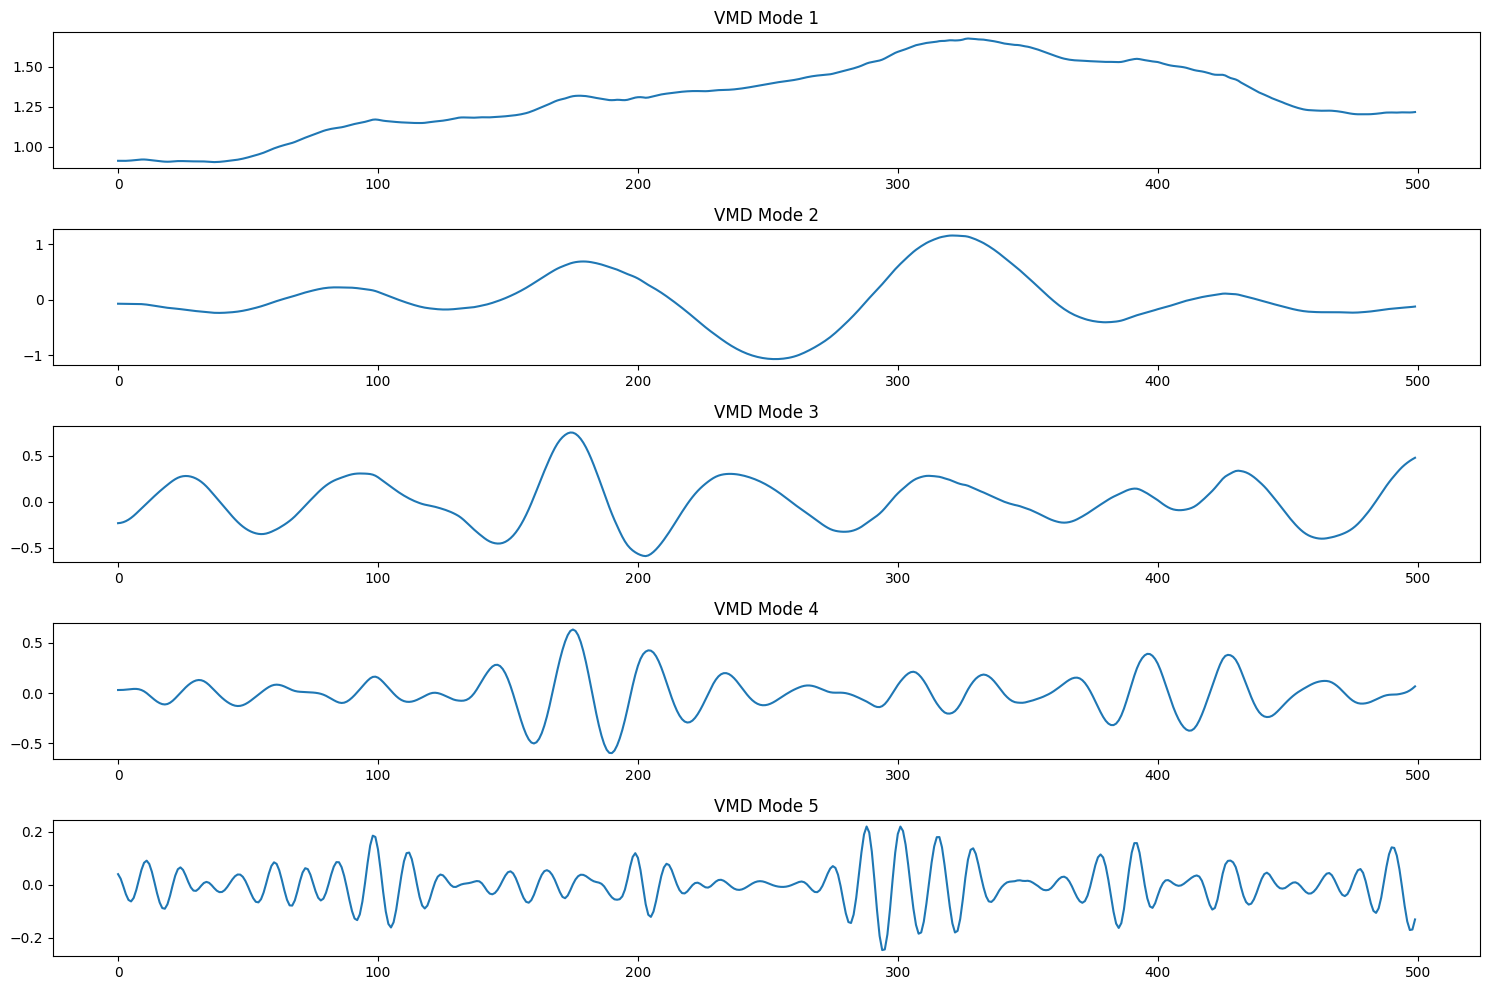

In [51]:
# Plot VMD modes
plt.figure(figsize=(15, 10))
for i in range(K):
    plt.subplot(K, 1, i+1)
    plt.plot(train_vmd_df[f'VMD_{i+1}'][:500])  # Plot first 500 points for visibility
    plt.title(f'VMD Mode {i+1}')
    plt.tight_layout()

plt.show()

In [53]:
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

def mean_absolute_percentage_error(y_true, y_pred):  # Custom MAPE function
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

def evaluate_hourly_forecast(y_true, y_pred, forecast_horizon):
    """
    Evaluates forecast metrics for each step in a multi-step horizon.

    Parameters:
    - y_true: 1D array of true values
    - y_pred: 1D array of predicted values
    - forecast_horizon: int, how many steps ahead were forecasted

    Returns:
    - pandas DataFrame with R², RMSE, MAPE, MAE for each step
    """
    assert len(y_true) == len(y_pred), "y_true and y_pred must be same length"
    assert len(y_true) % forecast_horizon == 0, "Data length must be divisible by forecast_horizon"

    steps = forecast_horizon
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    rows = []
    for h in range(steps):
        true_h = y_true[h::steps]
        pred_h = y_pred[h::steps]

        r2 = r2_score(true_h, pred_h)
        rmse = np.sqrt(mean_squared_error(true_h, pred_h))
        mape = mean_absolute_percentage_error(true_h, pred_h)
        mae = mean_absolute_error(true_h, pred_h)

        rows.append({
            'Hour': h + 1,
            'R²': r2,
            'RMSE': rmse,
            'MAPE': mape,
            'MAE': mae
        })

    return pd.DataFrame(rows).set_index('Hour')


In [56]:
# Ensure equal lengths
min_len = min(len(y_test), len(pred))
trim_len = min_len - (min_len % forecast_horizon)

y_test_trimmed = y_test[:trim_len]
pred_trimmed = pred[:trim_len]

# Evaluate
metrics_df = evaluate_hourly_forecast(y_test_trimmed, pred_trimmed, forecast_horizon=7)
print(metrics_df)



            R²      RMSE      MAPE       MAE
Hour                                        
1     0.964490  0.123311  6.312094  0.080323
2     0.967719  0.119177  6.355142  0.080626
3     0.969333  0.116349  5.871746  0.077161
4     0.969733  0.114793  6.193473  0.078810
5     0.970676  0.113583  6.319692  0.079673
6     0.965028  0.121123  6.304480  0.080491
7     0.970154  0.113201  6.110628  0.077340


## Rolling Loop

Outputs the same forecast every time- need to fix


### train

In [ ]:
# Start
n_past = 24
n_future = 24
target_col = 'WVHT'
y = df[target_col]

split = int(0.8 * len(df))

train_data = df[:split]

# calculate train vmd
# Apply VMD with compact parameter setup
params = {'alpha': 2000, 'tau': 0., 'K': 5, 'DC': 0, 'init': 1, 'tol': 1e-7}
u, _, _ = VMD(train_data[target_col], **params)

# Create DataFrame for VMD modes
vmd_train = pd.DataFrame(u.T, columns=[f'VMD_{i+1}' for i in range(params['K'])])

# Combine
features_train = pd.concat([vmd_train, train_data[['DPD', 'APD', 'MWD', 'WTMP']]], axis=1)   #.iloc[:-1]

# Scale
scaler = MinMaxScaler()
scaled_features_train = scaler.fit_transform(features_train)
y_train = train_data[target_col]

X_train_seq, y_train_seq = create_sequences(scaled_features_train, y_train, n_past, n_future)
print(X_train_seq.shape, y_train_seq.shape)

# Define LSTM Model
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=X_train.shape[1:]),
    LSTM(64, return_sequences=True),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(n_future)
])
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# STEP 9: Train Model
model.fit(X_train_seq, y_train_seq, epochs=30, batch_size=32)

(13988, 24, 9) (13988, 24)
Epoch 1/30


C:\Users\tarun\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


438/438 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - loss: 0.3832 - mae: 0.4292
Epoch 2/30
438/438 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 0.0840 - mae: 0.2112
Epoch 3/30
438/438 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 0.0633 - mae: 0.1814
Epoch 4/30
438/438 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 0.0538 - mae: 0.1669
Epoch 5/30
438/438 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 0.0504 - mae: 0.1606
Epoch 6/30
438/438 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 0.0386 - mae: 0.1397
Epoch 7/30
438/438 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 0.0367 - mae: 0.1370
Epoch 8/30
438/438 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 0.0325 - mae: 0.1284
Epoch 9/30
438/438 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - loss: 0.0301 - mae: 0.1233
Epoch 10/30
438/438 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - loss: 0.0269 - mae: 0.1164
Epoch 11/30
438/438 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - loss: 0.0260 - mae: 0.1130
Epoch 12/30
438/438 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - loss: 0.0255 - mae: 0.1130
Epoch 13/30
438/438 ━━━━

### test

In [ ]:
def vmd(series):
    # Apply VMD with compact parameter setup
    params = {'alpha': 2000, 'tau': 0., 'K': 5, 'DC': 0, 'init': 1, 'tol': 1e-7}
    u, _, _ = VMD(series, **params)

    # Create DataFrame for VMD modes
    return pd.DataFrame(u.T, columns=[f'VMD_{i+1}' for i in range(params['K'])])

from tqdm import tqdm

In [ ]:
# Rolling Forecast (>3s per)
test_data =df[split-n_past:] #overlap due to how create_sequences works

k = split
m=len(df)

rolling_pred = []
rolling_actual=[]

stride = 12
max_i = (len(test_data) - n_future) + 1  
for i in tqdm(range(0, max_i, stride)):
# for i in tqdm(range(0,5)):  # test
    y_train_rolling = y[:split + i]
    
    # Create and add VMD features
    vmd_features = vmd(y_train_rolling)
    other_features = test_data[['DPD', 'APD', 'MWD', 'WTMP']].iloc[i:i+n_past]
    features_train_rolling = pd.concat([vmd_features, other_features], axis=1).iloc[-n_past:]
    
    # Scale
    scaled_ftr = scaler.transform(features_train_rolling)
    

    pred = model.predict(scaled_ftr.reshape(1, *scaled_ftr.shape), verbose=0).squeeze()
    rolling_pred.append(pred)
    
    y_test_rolling = test_data[target_col].iloc[n_future+i:2*n_future+i]
    rolling_actual.append(y_test_rolling)
    
rolling_pred = np.vstack(rolling_pred)
rolling_actual = np.vstack(rolling_actual)

 94%|█████████▎| 274/293 [15:45<01:16,  4.01s/it]

In [ ]:
len([i for i in range(0, num_steps, 12)])

293

<function matplotlib.pyplot.show(close=None, block=None)>

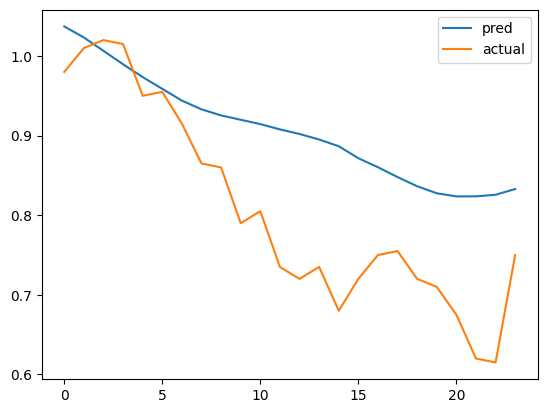

In [ ]:
# np.sqrt((pred[0]-actual[0])**2)
i=2
plt.plot(rolling_pred[i], label = 'pred')
plt.plot(rolling_actual[i], label='actual')
plt.legend()
plt.show

My concern is that there are extreme outlier in the final ndbc data, and apologize that I did not cap those value; the model have high accuracy but it might learn fron noise, I will not worry about this at this moment, since we do not have time to work on it, but it is something that is good to know : )